In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import scienceplots
import seaborn as sns
plt.style.use(["science", "no-latex"])
my_style = {
    "text.usetex": False,         
    "figure.constrained_layout.use": True,
    "figure.autolayout": False,
    "savefig.bbox": "tight",
    "savefig.pad_inches": 0.015,
    "font.size": 14,
    "axes.labelsize": 14,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "axes.titlesize": 14,
}
plt.rcParams.update(my_style)

In [2]:
import glob
import os

import pandas as pd

In [3]:
def read_csv_files(file_pattern):
    all_data = []
    for file in glob.glob(file_pattern):
        dataset_name = os.path.basename(os.path.dirname(file)).replace("_dataset", "")
        df = pd.read_csv(file, header=[0, 1], index_col=0)
        df = df.reset_index()
        df.columns = ["Classifier"] + [f"{col[1]}_{col[0]}" for col in df.columns[1:]]
        df["Dataset"] = dataset_name
        all_data.append(df)
    return pd.concat(all_data, ignore_index=True)


def process_classification_data(df):
    df = df[~df["Classifier"].isin(["Transformation", "Classifier"])]
    df = df.dropna().reset_index(drop=True)
    return df


def create_formatted_dataframe(df):
    metrics = ["Accuracy", "Matthews", "F1-Score"]

    # Create MultiIndex columns
    column_tuples = [(metric, method) for metric in metrics for method in ["PCA", "POLCA"]]
    columns = pd.MultiIndex.from_tuples(column_tuples)

    # Create the new DataFrame
    formatted_df = pd.DataFrame(columns=columns)

    for metric in metrics:
        formatted_df[(metric, "PCA")] = df[f"PCA_{metric}"]
        formatted_df[(metric, "POLCA")] = df[f"POLCA_{metric}"]

    formatted_df.index = pd.MultiIndex.from_frame(df[["Dataset", "Classifier"]])

    return formatted_df


def clean_latex_table(latex_table):
    lines = latex_table.split("\n")
    cleaned_lines = []
    for line in lines:
        if "multicolumn" in line and "Classifier" in line:
            continue
        if "Classifier &" in line:
            line = line.replace("Classifier &", "")
        cleaned_lines.append(line)
    return "\n".join(cleaned_lines)

In [4]:
# Main execution
print("Starting main execution")
raw_classification_metrics = read_csv_files("experiments/*/classification_metrics.csv")
classification_metrics = process_classification_data(raw_classification_metrics)

Starting main execution


In [5]:
formatted_df = create_formatted_dataframe(classification_metrics)

In [6]:
print("\nFormatted DataFrame:")
formatted_df


Formatted DataFrame:


Accuracy       Matthews       F1-Score      
                                      PCA POLCA      PCA POLCA      PCA POLCA
Dataset     Classifier                                                       
organcmnist Gaussian Naive Bayes     0.66  0.69     0.62  0.65     0.65  0.68
            Linear SVM               0.68  0.70     0.64  0.66     0.67  0.68
            Logistic Regression      0.65  0.67     0.60  0.63     0.63  0.66
            Perceptron               0.52  0.56     0.49  0.53     0.53  0.53
            Ridge Classifier         0.57  0.61     0.52  0.57     0.53  0.60
organsmnist Gaussian Naive Bayes     0.44  0.52     0.37  0.45     0.45  0.50
            Linear SVM               0.48  0.49     0.40  0.43     0.47  0.48
            Logistic Regression      0.44  0.47     0.36  0.41     0.42  0.47
            Perceptron               0.29  0.38     0.23  0.32     0.21  0.36
            Ridge Classifier         0.43  0.46     0.34  0.39     0.37  0.44
pathmnist   Gaussian Naive Bayes     0.28  0.31     0.18  0.26     0.21  0.27
            Linear SVM               0.52  0.76     0.46  0.73     0.51  0.75
            Logistic Regression      0.56  0.76     0.50  0.73     0.52  0.76
            Perceptron               0.41  0.65     0.37  0.61     0.32  0.61
            Ridge Classifier         0.48  0.70     0.43  0.66     0.38  0.67
breastmnist Gaussian Naive Bayes     0.68  0.64     0.20  0.13     0.64  0.62
            Linear SVM               0.70  0.68     0.28  0.20     0.68  0.64
            Logistic Regression      0.70  0.70     0.26  0.29     0.66  0.61
            Perceptron               0.55  0.51     0.05  0.10     0.56  0.52
            Ridge Classifier         0.70  0.66     0.38  0.13     0.71  0.61
bloodmnist  Gaussian Naive Bayes     0.64  0.48     0.58  0.40     0.64  0.45
            Linear SVM               0.66  0.74     0.61  0.70     0.67  0.74
            Logistic Regression      0.67  0.73     0.62  0.68     0.68  0.73
            Perceptron               0.58  0.53     0.53  0.49     0.57  0.47
            Ridge Classifier         0.64  0.67     0.59  0.61     0.62  0.65
dermamnist  Gaussian Naive Bayes     0.13  0.66     0.04  0.04     0.04  0.53
            Linear SVM               0.67  0.67     0.18  0.19     0.57  0.56
            Logistic Regression      0.63  0.67     0.21  0.18     0.59  0.56
            Perceptron               0.13  0.63     0.07  0.32     0.08  0.61
            Ridge Classifier         0.62  0.67     0.24  0.14     0.59  0.55
octmnist    Gaussian Naive Bayes     0.46  0.29     0.28  0.07     0.43  0.19
            Linear SVM               0.44  0.46     0.25  0.30     0.41  0.37
            Logistic Regression      0.44  0.48     0.25  0.35     0.42  0.39
            Perceptron               0.38  0.40     0.23  0.26     0.28  0.33
            Ridge Classifier         0.42  0.43     0.23  0.29     0.40  0.32
retinamnist Gaussian Naive Bayes     0.49  0.48     0.23  0.00     0.45  0.31
            Linear SVM               0.51  0.41     0.30  0.21     0.52  0.43
            Logistic Regression      0.54  0.48     0.32  0.24     0.53  0.44
            Perceptron               0.48  0.38     0.29  0.16     0.51  0.35
            Ridge Classifier         0.50  0.39     0.28  0.23     0.51  0.43
fmnist      Gaussian Naive Bayes     0.75  0.76     0.72  0.74     0.75  0.76
            Linear SVM               0.80  0.82     0.78  0.80     0.79  0.82
            Logistic Regression      0.79  0.81     0.76  0.79     0.78  0.81
            Perceptron               0.75  0.74     0.73  0.72     0.72  0.73
            Ridge Classifier         0.73  0.79     0.71  0.77     0.71  0.79

In [34]:
# Generate LaTeX table
latex_table = formatted_df.to_latex(
    multirow=True,
    multicolumn=True,
    caption="Classification Metrics Comparison",
    label="tab:classification_metrics",
    position="htbp",
    float_format="%.2f",
    column_format="llrrrrrr",
)
print(latex_table)
with open("experiments/classifier_metric_comparison.tex", "w") as f:
    f.write(latex_table)

\begin{table}[htbp]
\caption{Classification Metrics Comparison}
\label{tab:classification_metrics}
\begin{tabular}{llrrrrrr}
\toprule
 &  & \multicolumn{2}{r}{Accuracy} & \multicolumn{2}{r}{Matthews} & \multicolumn{2}{r}{F1-Score} \\
 &  & PCA & POLCA & PCA & POLCA & PCA & POLCA \\
Dataset & Classifier &  &  &  &  &  &  \\
\midrule
\multirow[t]{5}{*}{organcmnist} & Gaussian Naive Bayes & 0.66 & 0.69 & 0.62 & 0.65 & 0.65 & 0.68 \\
 & Linear SVM & 0.68 & 0.70 & 0.64 & 0.66 & 0.67 & 0.68 \\
 & Logistic Regression & 0.65 & 0.67 & 0.60 & 0.63 & 0.63 & 0.66 \\
 & Perceptron & 0.52 & 0.56 & 0.49 & 0.53 & 0.53 & 0.53 \\
 & Ridge Classifier & 0.57 & 0.61 & 0.52 & 0.57 & 0.53 & 0.60 \\
\cline{1-8}
\multirow[t]{5}{*}{organsmnist} & Gaussian Naive Bayes & 0.44 & 0.52 & 0.37 & 0.45 & 0.45 & 0.50 \\
 & Linear SVM & 0.48 & 0.49 & 0.40 & 0.43 & 0.47 & 0.48 \\
 & Logistic Regression & 0.44 & 0.47 & 0.36 & 0.41 & 0.42 & 0.47 \\
 & Perceptron & 0.29 & 0.38 & 0.23 & 0.32 & 0.21 & 0.36 \\
 & Ridge Classifi

In [8]:
# Reshape the DataFrame
df_long = (
    formatted_df.stack(level=[0, 1], future_stack=True)
    .reset_index()
    .rename(columns={"level_2": "Metric", "level_3": "Method", 0: "Value"})
)
df_long

,Dataset,Classifier,Metric,Method,Value
0,organcmnist,Gaussian Naive Bayes,Accuracy,PCA,0.66
1,organcmnist,Gaussian Naive Bayes,Accuracy,POLCA,0.69
2,organcmnist,Gaussian Naive Bayes,Matthews,PCA,0.62
3,organcmnist,Gaussian Naive Bayes,Matthews,POLCA,0.65
4,organcmnist,Gaussian Naive Bayes,F1-Score,PCA,0.65
...,...,...,...,...,...
265,fmnist,Ridge Classifier,Accuracy,POLCA,0.79
266,fmnist,Ridge Classifier,Matthews,PCA,0.71
267,fmnist,Ridge Classifier,Matthews,POLCA,0.77
268,fmnist,Ridge Classifier,F1-Score,PCA,0.71


In [9]:
def normalize_and_aggregate_results(df_long):
    """
    Normalize 'Value' within each Dataset, then aggregate by taking the mean across datasets.

    :param df_long: Pandas DataFrame with columns: Dataset, Classifier, Metric, Method, Value
    :return: Aggregated DataFrame with normalized mean values
    """
    # Ensure 'Value' is numeric
    df_long["Value"] = pd.to_numeric(df_long["Value"], errors="coerce")

    # Normalize 'Value' within each Dataset
    df_long["Normalized_Value"] = (
        df_long[["Dataset", "Value"]].groupby("Dataset").transform(lambda x: (x - x.min()) / (x.max() - x.min()))
    )

    # Calculate the mean of normalized values across datasets
    df_aggregated = df_long.groupby(["Classifier", "Metric", "Method"])["Normalized_Value"].mean().reset_index()

    return df_aggregated

In [10]:
df_norm = normalize_and_aggregate_results(df_long)
df_norm

,Classifier,Metric,Method,Normalized_Value
0,Gaussian Naive Bayes,Accuracy,PCA,0.638825
1,Gaussian Naive Bayes,Accuracy,POLCA,0.685544
2,Gaussian Naive Bayes,F1-Score,PCA,0.584740
3,Gaussian Naive Bayes,F1-Score,POLCA,0.567244
4,Gaussian Naive Bayes,Matthews,PCA,0.324543
5,Gaussian Naive Bayes,Matthews,POLCA,0.229774
6,Linear SVM,Accuracy,PCA,0.864062
7,Linear SVM,Accuracy,POLCA,0.952028
8,Linear SVM,F1-Score,PCA,0.819362
9,Linear SVM,F1-Score,POLCA,0.889536


In [32]:
def create_metric_comparison_plots(df_aggregated, output_prefix="metric_comparison"):
    """
    Create separate bar plots for each metric, comparing PCA and POLCA methods across classifiers using pyplot.

    :param df_aggregated: Pandas DataFrame with columns: Classifier, Metric, Method, Normalized_Value
    :param output_prefix: Prefix for the output files
    """
    # Get unique metrics
    metrics = df_aggregated["Metric"].unique()
    metrics = ["Accuracy"]
    for metric in metrics:
        # Filter data for the current metric
        metric_data = df_aggregated[df_aggregated["Metric"] == metric]

        # Get unique classifiers and methods
        classifiers = metric_data["Classifier"].unique()
        methods = metric_data["Method"].unique()

        # Set up the plot
        fig, ax = plt.subplots(figsize=(4,4))

        # Set width of bars and positions
        bar_width = 0.5
        r1 = range(len(classifiers))
        r2 = [x + bar_width for x in r1]
        # Use a grayscale colormap
        cmap = plt.get_cmap("Greys")
        colors = [cmap(0.5), cmap(0.0)]  # Darker gray for PCA, lighter gray for POLCA

        # Create bars
        for i, method in enumerate(methods):
            method_data = metric_data[metric_data["Method"] == method]
            positions = r1 if i == 0 else r2
            ax.bar(
                positions,
                method_data["Normalized_Value"],
                width=bar_width,
                label=method,
                alpha=0.5,
                facecolor=colors[i],
                edgecolor="k"
            )

        # Customize the plot
        ax.set_xlabel("")
        ax.set_ylabel(f"{metric} across all datasets")
        ax.set_title(f"PCA and POLCA: {metric}")
        ax.set_xticks([r + bar_width / 2 for r in range(len(classifiers))])
        classifiers[list(classifiers).index("Gaussian Naive Bayes")]="GaussianNB"
        ax.set_xticklabels(classifiers, rotation=35, ha="right",va="top")
        ax.set_ylim(0, 1.1)

        # Add legend
        ax.legend()        

        # Add value labels on the bars
        for i, method in enumerate(methods):
            method_data = metric_data[metric_data["Method"] == method]
            positions = r1 if i == 0 else r2
            for j, value in enumerate(method_data["Normalized_Value"]):
                ax.text(positions[j], value, f"{value:.2f}", ha="center", va="bottom",fontsize="small")

        # Adjust layout and save
        #plt.tight_layout()
        plt.savefig("experiments/classifier_metric_comparison_plot.pdf", dpi=300, bbox_inches="tight")
        plt.plot()

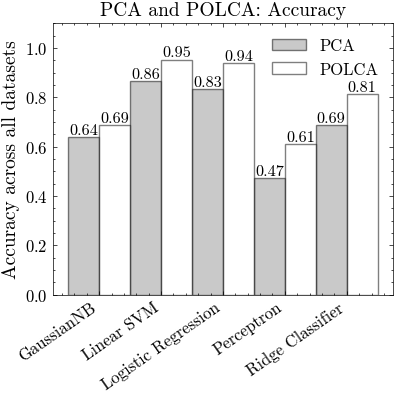

In [33]:
# plt.style.use('seaborn-v0_8-paper')
create_metric_comparison_plots(df_norm)

In [24]:
 plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'bright',
 'cjk-jp-font',
 'cjk-kr-font',
 'cjk-sc-font',
 'cjk-tc-font',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'grid',
 'high-contrast',
 'high-vis',
 'ieee',
 'latex-sans',
 'light',
 'muted',
 'nature',
 'no-latex',
 'notebook',
 'pgf',
 'retro',
 'russian-font',
 'sans',
 'scatter',
 'science',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'std-colors',
 'tableau-colorblind10',
 'turkish-font',
 'vibrant']